# Importación y preprocesamiento


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from fitter import Fitter, get_common_distributions, get_distributions

In [2]:
# Abrimos y ajustamos los datos para leerlos
datos_pacientes = pd.read_csv("Datos.csv",sep = ";")
datos_pacientes["Marca de tiempo"] = pd.to_datetime(datos_pacientes["Marca de tiempo"])
datos_operaciones = pd.read_csv("Datos operaciones origen urgencias.csv")

datos_operaciones = datos_operaciones.iloc[:,:5]
datos_operaciones = datos_operaciones.drop(datos_operaciones.columns[3],axis = 1)

In [3]:
#Estas son las áreas que aparecen en el diagrama entregado
areas_mapa_profe = ["URG101_003","DIV101_603","DIV101_604","DIV101_703","DIV102_203","DIV103_107","DIV103_204",
"DIV104_602","OPR101_011","OPR101_033","OPR102_001","OPR102_003","End"]

In [4]:
# Lo primero que haremos será filtrar los datos para obtener el nodo "Outisde"
filtro_fuera = (~datos_pacientes["Area"].isin(areas_mapa_profe))
datos_pacientes.loc[filtro_fuera,"Area"] = "Outside"

In [5]:
#Eliminamos las filas donde el valor actual y el anterior corresponden al nodo outside, dejamos el primero,
#marcando así la entrada del paciente al nodo outside, pero solo una vez 
filtro_doble_fuera = (~datos_pacientes["Area"].isin(areas_mapa_profe))&((~datos_pacientes["Area"].shift(1).isin(areas_mapa_profe)))
datos_pacientes = datos_pacientes[~filtro_doble_fuera]


In [6]:
datos_pacientes["Hora derivacion"] = datos_pacientes["Marca de tiempo"].shift(-1)
datos_pacientes["Estadia"] = datos_pacientes["Hora derivacion"]  - datos_pacientes["Marca de tiempo"]
datos_pacientes["Estadia"] = datos_pacientes["Estadia"]/np.timedelta64(1,"h")
datos_pacientes["Siguiente Área"] = datos_pacientes["Area"].shift(-1)

In [7]:
import pylab as pl

In [87]:
plt.style.use('ggplot')

Probabilidad de transición desde la sala de urgencias (DIV101_703)
Outside       34.680135
End           23.456790
DIV103_204    11.111111
DIV104_602     7.182941
DIV101_604     6.060606
DIV101_603     5.162738
DIV103_107     5.050505
DIV102_203     4.040404
OPR102_003     3.030303
OPR101_033     0.112233
OPR102_001     0.112233
Name: Siguiente Área, dtype: float64


Text(0.5, 0, 'Horas')

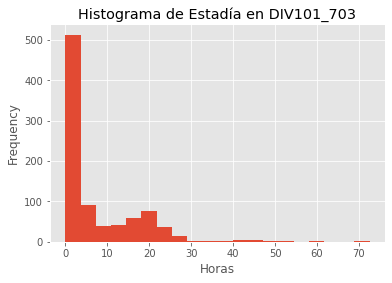

In [88]:
area = "DIV101_703"
derivacion_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Siguiente Área"]
print(f"Probabilidad de transición desde la sala de urgencias ({area})")
transiciones = (derivacion_urgencia.value_counts()/derivacion_urgencia.shape[0])*100
print(transiciones)
estadia_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
hist = estadia_urgencia.plot.hist(title = f"Histograma de Estadía en {area}",bins = 20)
hist.set_xlabel("Horas")

## Analizamos caso a a caso

In [8]:
set_pacientes = set(datos_pacientes["Case ID"])
entrada = "URG101_003"
salida = "End"
dic_info_pacientes = dict.fromkeys(set_pacientes,{})
for paciente in set_pacientes:
    info_paciente = datos_pacientes[datos_pacientes["Case ID"] == paciente]
    hora_entrada = info_paciente.iloc[0]["Marca de tiempo"]
    hora_salida = info_paciente.iloc[-1]["Marca de tiempo"]
    dic_paciente ={"Entrada":hora_entrada,"Salida":hora_salida}
    duracion = hora_salida - hora_entrada
    dic_paciente["Duracion"] = duracion/np.timedelta64(1,"h")
    procedimiento = list(info_paciente["Area"])
    ruta = "".join(procedimiento)
    dic_paciente["Ruta"] = ruta
    dic_info_pacientes[paciente] = dic_paciente
    

In [9]:
df_info_pacientes = pd.DataFrame(dic_info_pacientes).T


# Estado actual de los KPI

### Lead time promedio

In [91]:
df_info_pacientes["Duracion"].mean()

81.9152056901192

### 5% de peores casos

In [92]:
duraciones = df_info_pacientes["Duracion"].sort_values()
n_5_peor = int(duraciones.shape[0]*0.05)
pct_5_peores_casos = duraciones.iloc[-n_5_peor:]
print(pct_5_peores_casos.mean())
print(pct_5_peores_casos.min())
print(pct_5_peores_casos.max())

971.1093023255813
453.93333333333334
4517.7


# Analizamos las llegadas

### Histograma de llegadas(solo para llegadas en menos de 24 horas)

Text(0.5, 1.0, 'Tiempo entre llegadas (Para tiempos menores a 24 horas)')

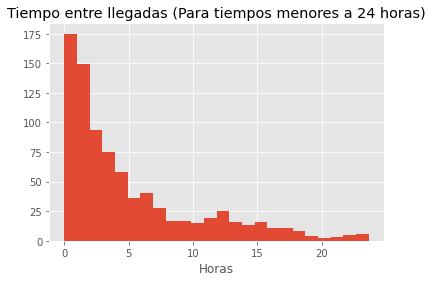

In [93]:
llegadas = df_info_pacientes["Entrada"].sort_values()
tiempo_entre_llegadas = (llegadas.shift(-1) - llegadas)/np.timedelta64(1,"h")
hist = tiempo_entre_llegadas[tiempo_entre_llegadas < 24].hist(bins = 24)
hist.set_xlabel("Horas")
hist.set_title("Tiempo entre llegadas (Para tiempos menores a 24 horas)")

,sumsquare_error,aic,bic,kl_div
halfcauchy,0.027976,820.437217,-8680.704904,inf
foldcauchy,0.028391,824.091098,-8661.541248,inf
powerlognorm,0.029278,807.510133,-8628.871488,inf
pareto,0.030699,807.311675,-8595.657400,inf
betaprime,0.031229,802.393090,-8574.490752,inf


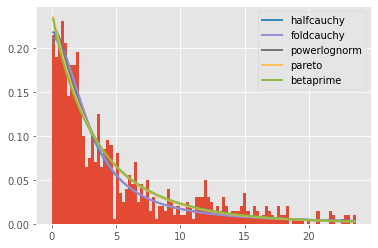

In [103]:
tiempo_filtrado = tiempo_entre_llegadas[tiempo_entre_llegadas < 24]
fit_llegadas_exp = Fitter(tiempo_filtrado)
fit_llegadas_exp.fit()
fit_llegadas_exp.summary()

,sumsquare_error,aic,bic,kl_div
expon,0.040003,796.096339,-8379.236682,inf


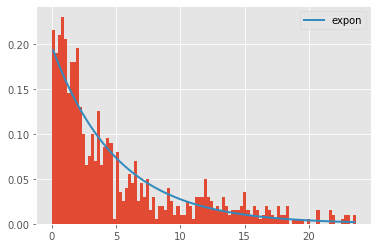

In [105]:
tiempo_filtrado = tiempo_entre_llegadas[tiempo_entre_llegadas < 24]
fit_llegadas_exp = Fitter(tiempo_filtrado, distributions=["expon"])
fit_llegadas_exp.fit()
fit_llegadas_exp.summary()

In [107]:
ajuste_exponencial = fit_llegadas_exp.get_best(method = "sumsquare_error")
ajuste_exponencial

{'expon': (0.0, 5.058066429418743)}

Text(0.5, 0, 'Hora del día')

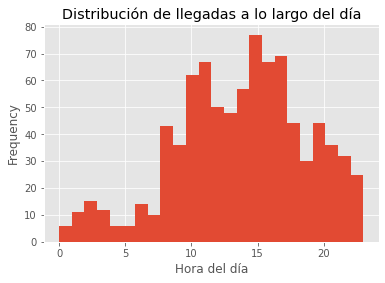

In [15]:
horas_entrada = [entrada.hour for entrada in df_info_pacientes["Entrada"]]
df_info_pacientes["Hora entrada"] = horas_entrada
hist = df_info_pacientes["Hora entrada"].plot.hist(bins = 24,title = "Distribución de llegadas a lo largo del día")
hist.set_xlabel("Hora del día")

# Analisis de operaciones

In [16]:
print(datos_operaciones["DURACION (hrs)"].mean())
print(datos_operaciones["DURACION (hrs)"].max())
print(datos_operaciones["DURACION (hrs)"].min())

2.4310679611650494
4.1
0.0


Text(0.5, 0, 'Horas')

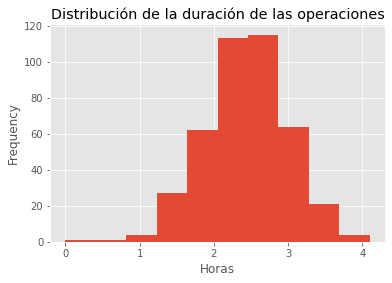

In [17]:
hist = datos_operaciones["DURACION (hrs)"].plot.hist()
hist.set_title("Distribución de la duración de las operaciones")
hist.set_xlabel("Horas")

Text(0.5, 1.0, 'Cantidad de operaciones recibidas por paciente')

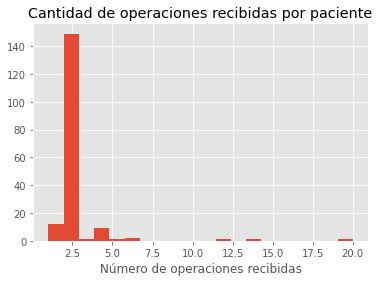

In [18]:
hist = datos_operaciones["ID"].value_counts().hist(bins = 20)
hist.set_xlabel("Número de operaciones recibidas")
hist.set_title("Cantidad de operaciones recibidas por paciente")

Text(0, 0.5, 'Número de operaciones realizadas')

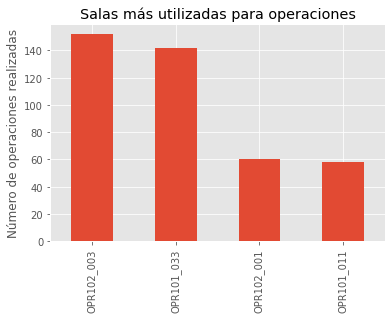

In [19]:
barplot = datos_operaciones["SALA OPERACIONES"].value_counts().plot.bar()
barplot.set_title("Salas más utilizadas para operaciones")
barplot.set_ylabel("Número de operaciones realizadas")

In [20]:
datos_operaciones

,ID,SALA OPERACIONES,FECHA E INICIO,DURACION (hrs)
0,14548704,OPR101_011,2018-01-02 10:15:00.000,2.8
1,14557024,OPR101_011,2017-12-22 13:37:00.000,1.6
2,14557024,OPR101_011,2018-01-12 15:36:00.000,1.2
3,14562339,OPR101_011,2018-01-03 15:56:00.000,1.3
4,14568735,OPR101_011,2018-01-05 18:34:00.000,3.2
...,...,...,...,...
407,14775043000,OPR102_003,2018-03-15 15:17:00.000,2.4
408,14799531000,OPR102_003,2018-03-26 13:02:00.000,3.3
409,14867095000,OPR102_003,2018-04-17 18:25:00.000,3.4
410,14973437000,OPR102_003,2018-05-30 13:42:00.000,2.4


In [21]:
areas_mapa_profe

['URG101_003',
 'DIV101_603',
 'DIV101_604',
 'DIV101_703',
 'DIV102_203',
 'DIV103_107',
 'DIV103_204',
 'DIV104_602',
 'OPR101_011',
 'OPR101_033',
 'OPR102_001',
 'OPR102_003',
 'End']

# Distribuciones por sala

In [10]:
from scipy import stats

In [23]:
dic_distribuciones = dict.fromkeys(areas_mapa_profe)
for area in areas_mapa_profe:
    try : 
        estadia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
        estadia = np.array(estadia)
        f = Fitter(estadia,distributions = ["expon","beta","lognorm","norm",])
        f.fit()
        best = f.get_best(method = "sumsquare_error")
        dic_distribuciones[area] = best
        print(area,"lista")
    
    except:
        continue
        


URG101_003 lista
DIV101_603 lista
DIV101_604 lista
DIV101_703 lista
DIV102_203 lista
DIV103_107 lista
DIV103_204 lista
DIV104_602 lista
OPR101_011 lista
OPR101_033 lista
OPR102_001 lista


OPR102_003 lista


## Test de bondad 
Recordar que **si el p-value es menor a 0.05 implica que la distribución ajusta de buena manera a los datos**. Si el p-values es mayor a 0.05 significa que no hay información suficiente para justificar que la distribución ajusta de buena manera.

In [24]:
import math
for area in areas_mapa_profe:
    if area != 'End':
        estadia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
        estadia = np.array(estadia)
        distribucion = list(dic_distribuciones[area].keys())[0]

        if distribucion == 'beta':
            param_a = dic_distribuciones[area]['beta'][0]
            param_b = dic_distribuciones[area]['beta'][1]
            loc = dic_distribuciones[area]['beta'][2]
            scale = dic_distribuciones[area]['beta'][3]
            esperado = (np.random.beta(a=param_a, b=param_b, size=len(estadia)) - loc) / scale

        elif distribucion == 'lognorm':
            s = dic_distribuciones[area]['lognorm'][0]
            loc = dic_distribuciones[area]['lognorm'][1]
            scale = dic_distribuciones[area]['lognorm'][2]
                
            esperado = (np.random.lognormal(mean=math.log(scale), sigma=s, size=len(estadia)) - loc) / scale

        else:
            print('Distribucion desconocida')

        test_bondad = stats.chisquare(f_obs = estadia, f_exp = esperado)
        print(area)
        resultado_test = list(test_bondad)
        print(f'Estadístico:{resultado_test[0]} p-value: {resultado_test[1]} \n')

URG101_003
Estadístico:12638078.850782946 p-value: 0.0 

DIV101_603
Estadístico:619327148948223.9 p-value: 0.0 

DIV101_604
Estadístico:1936609018192349.0 p-value: 0.0 

DIV101_703
Estadístico:1867711104957.9626 p-value: 0.0 

DIV102_203
Estadístico:4.560246072839681e+17 p-value: 0.0 

DIV103_107
Estadístico:231555664610548.38 p-value: 0.0 

DIV103_204
Estadístico:577668802390145.8 p-value: 0.0 

DIV104_602
Estadístico:1.4381354933849255e+20 p-value: 0.0 

OPR101_011
Estadístico:7241.892795703271 p-value: 0.0 

OPR101_033
Estadístico:-30534.52758811228 p-value: 1.0 

OPR102_001
Estadístico:-8383.142685368659 p-value: 1.0 

OPR102_003
Estadístico:275.9708010748603 p-value: 2.3152360752580137e-09 



In [25]:
dic_distribuciones

{'URG101_003': {'beta': (0.9963865319265526,
   7.549140779895584,
   -5.8548793004373246e-30,
   22.24393218386804)},
 'DIV101_603': {'beta': (0.3616704354973971,
   165.16296501053603,
   -7.412371308927781e-26,
   6922.807468149733)},
 'DIV101_604': {'beta': (0.45703588480386004,
   648.4486740488123,
   -8.513612931753873e-29,
   35054.048864844575)},
 'DIV101_703': {'beta': (0.5703786223184792,
   110.83109431271232,
   -1.462673655225481e-28,
   437.32033985936954)},
 'DIV102_203': {'beta': (0.24377071043553353,
   285.52176298361917,
   -1.187635564202615e-26,
   5018.705281761797)},
 'DIV103_107': {'beta': (0.39836402842306595,
   206.40113822847783,
   -1.5712666431312037e-28,
   10158.914732260619)},
 'DIV103_204': {'beta': (0.4888117957179907,
   109.8607935613231,
   -1.5936649681747108e-28,
   5313.91647884571)},
 'DIV104_602': {'beta': (0.15192779271070977,
   194.10258963560304,
   -5.156397043984947e-29,
   8814.947865303959)},
 'OPR101_011': {'beta': (0.580887388605725

In [26]:
dic_histogramas= {}

{'lognorm': (1.1325392177517544, -0.1631080499945431, 3.01277091110916)}


,sumsquare_error,aic,bic,kl_div
lognorm,0.033620,814.881030,-8519.048424,inf
chi2,0.037207,794.198271,-8433.592650,inf
beta,0.062616,758.059596,-7988.039146,inf
norm,0.228845,853.969495,-6908.970436,inf


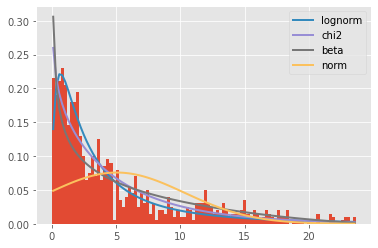

In [27]:
llegadas = df_info_pacientes["Entrada"].sort_values()
tiempo_entre_llegadas = (llegadas.shift(-1) - llegadas)/np.timedelta64(1,"h")
duracion_operaciones = tiempo_entre_llegadas[tiempo_entre_llegadas < 24]
duracion_operaciones = np.array(duracion_operaciones)
f = Fitter(duracion_operaciones,distributions = ["norm","beta","lognorm","chi2"])
f.fit()
a = f.get_best(method = "sumsquare_error")
print(a)
f.summary()


In [28]:
dic_histogramas["Tiempo_entre_llegadas"] = a

# Transiciones entre salas
Aqui se realiza un mapa de calor

In [29]:
df_heatmap = pd.DataFrame(index = areas_mapa_profe,columns = areas_mapa_profe)

In [30]:
areas_mapa_profe.append("Outside")

In [31]:
for area in areas_mapa_profe:
    derivacion_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Siguiente Área"]
    transiciones = (derivacion_urgencia.value_counts()/derivacion_urgencia.shape[0])*100
    df_heatmap[area] = transiciones

In [32]:
df_heatmap.fillna(0)

,URG101_003,DIV101_603,DIV101_604,DIV101_703,DIV102_203,DIV103_107,DIV103_204,DIV104_602,OPR101_011,OPR101_033,OPR102_001,OPR102_003,End,Outside
URG101_003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.510204,0.826446,1.724138,2.112676,0.000000,0.657895,99.88466,0.000000
DIV101_603,0.000000,0.000000,0.000000,5.162738,1.408451,1.923077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.654867
DIV101_604,0.000000,0.000000,0.000000,6.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.433628
DIV101_703,99.084668,0.000000,0.000000,0.000000,0.000000,0.000000,1.020408,0.826446,1.724138,12.676056,0.000000,1.315789,0.00000,0.221239
DIV102_203,0.114416,1.666667,0.000000,4.040404,0.000000,0.000000,0.000000,0.000000,48.275862,0.000000,1.666667,0.000000,0.00000,0.884956
DIV103_107,0.000000,1.666667,0.000000,5.050505,0.000000,0.000000,0.000000,0.000000,5.172414,0.000000,1.666667,0.000000,0.00000,0.442478
DIV103_204,0.000000,0.000000,0.000000,11.111111,0.000000,0.000000,0.000000,0.000000,0.000000,48.591549,0.000000,9.868421,0.00000,2.876106
DIV104_602,0.114416,0.000000,0.000000,7.182941,0.000000,0.000000,12.755102,0.000000,1.724138,7.746479,0.000000,1.973684,0.00000,3.539823
OPR101_011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.826446,0.000000,0.000000,95.000000,0.000000,0.00000,0.000000
OPR101_033,0.000000,0.000000,0.000000,0.112233,0.000000,0.000000,4.591837,0.000000,0.000000,0.000000,0.000000,82.894737,0.00000,1.327434


<AxesSubplot:>

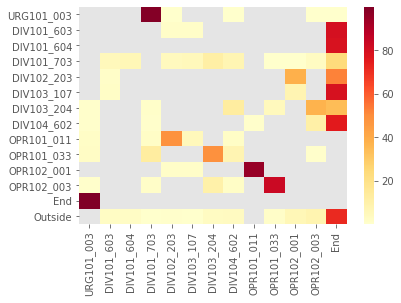

In [33]:
import seaborn as sns
sns.heatmap(df_heatmap.T,annot = False,cmap = "YlOrRd")

# Pacientes por día

In [34]:
salas_div  = areas_mapa_profe[:-5]

In [35]:
estadias_div = []
for paciente in set_pacientes :
    info_pacientes = datos_pacientes[datos_pacientes["Case ID"] == paciente]
    info_hospitalizacion = info_pacientes[info_pacientes["Area"].isin(salas_div)]
    estadia = np.sum(info_pacientes["Estadia"])
    estadias_div.append(estadia)
estadia_serie = pd.Series(estadias_div)
estadia_serie = estadia_serie[(estadia_serie >0)]
print("Media de estadia en div (suma)",estadia_serie.mean())

Media de estadia en div (suma) 17.17735714285716


In [36]:
import datetime

In [37]:
def convertir_fecha(date):
    fecha = datetime.datetime.strftime(date,"%Y-%m-%d")
    return fecha

In [38]:
df_info_pacientes["Fecha_entrada"] = [convertir_fecha(df_info_pacientes["Entrada"].iloc[i]) for i in range(df_info_pacientes["Entrada"].shape[0])]

df_info_pacientes

,Entrada,Salida,Duracion,Ruta,Hora entrada,Fecha_entrada
14817280,2018-03-30 18:14:00,2018-03-30 22:06:00,3.866667,URG101_003DIV101_703DIV103_204End,18,2018-03-30
14931970,2018-05-13 16:37:00,2018-05-14 00:14:00,7.616667,URG101_003DIV101_703DIV102_203OPR102_001OPR101...,16,2018-05-13
14888963,2018-04-25 16:06:00,2018-04-26 12:26:00,20.333333,URG101_003DIV101_703OutsideEnd,16,2018-04-25
14696460,2018-02-15 12:04:00,2018-02-16 15:55:00,27.85,URG101_003DIV101_703DIV101_604End,12,2018-02-15
14579725,2018-01-04 21:05:00,2018-01-04 22:46:00,1.683333,URG101_003DIV101_703End,21,2018-01-04
...,...,...,...,...,...,...
14888950,2018-04-25 17:31:00,2018-05-15 14:18:00,476.783333,URG101_003DIV101_703OutsideDIV101_603End,17,2018-04-25
14682104,2018-02-08 14:27:00,2018-02-09 13:53:00,23.433333,URG101_003DIV101_703DIV104_602End,14,2018-02-08
14716923,2018-02-23 10:13:00,2018-02-23 18:39:00,8.433333,URG101_003DIV101_703End,10,2018-02-23
14716925,2018-02-23 17:47:00,2018-02-24 14:22:00,20.583333,URG101_003DIV101_703OutsideEnd,17,2018-02-23


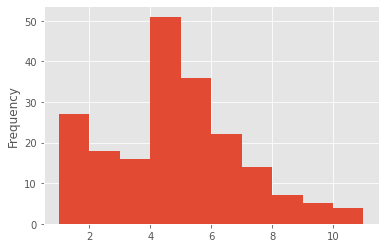

In [39]:
hist = df_info_pacientes["Fecha_entrada"].value_counts().plot.hist()


In [40]:
datos_atencion_urg = pd.read_csv("Datos_atencion_urg.csv")
ids_atencion = datos_atencion_urg["ID"]
set_atencion_urg = set(ids_atencion)
for paciente in set_pacientes:
    if paciente not in set_atencion_urg:
        print("Match")

Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Matc

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

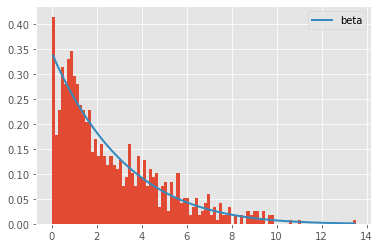

In [41]:
estadia = datos_pacientes[datos_pacientes["Area"] == "URG101_003"]["Estadia"]
estadia = np.array(estadia)
f = Fitter(estadia,distributions = ["beta"])
f.fit()
hist = f.summary()
plt.set_title("Estadia en URG101_003 distribución ajustada")
plt.set_xlabel("Horas")

In [ ]:
help(Fitter.summary)

# Ajuste de distribuciones de estadias OPR, DIV y URG

### Distribución Operaciones

In [63]:
datos_operaciones['SALA OPERACIONES'].value_counts()

OPR102_003    152
OPR101_033    142
OPR102_001     60
OPR101_011     58
Name: SALA OPERACIONES, dtype: int64

Cantidad de datos de estadias en operaciones 412
2.4310679611650494


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa330dbf6d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa330dbf940>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa330dbf3a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa330dbfee0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa330dd41f0>],
 'means': []}

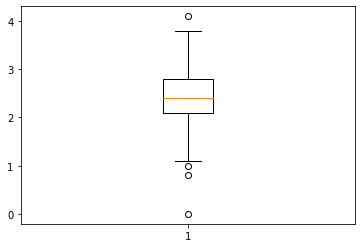

In [64]:
estadias_opr = datos_operaciones['DURACION (hrs)']
print(f'Cantidad de datos de estadias en operaciones {len(datos_operaciones)}')
print(np.mean(estadias_opr))
plt.boxplot(estadias_opr)

,sumsquare_error,aic,bic,kl_div
gennorm,19.606350,559.010495,-1236.546913,inf
johnsonsu,19.611286,533.397316,-1230.422174,inf
exponweib,19.614444,548.306045,-1230.355838,inf
skewnorm,19.615331,551.793813,-1236.358225,inf
powernorm,19.616234,548.759231,-1236.339274,inf


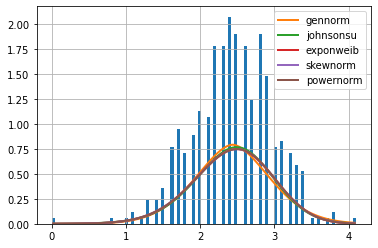

In [65]:
fit_opr = Fitter(estadias_opr)
fit_opr.fit()
fit_opr.summary()

The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 19.606349881457756  and p value is: 9.51524333525633e-06
Null Hypothesis is rejected -> La distribución no ajusta los datos


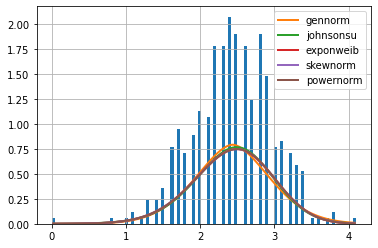

In [66]:
result_opr = fit_opr.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_opr['sumsquare_error'][0]

print("The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis -> La distribución ajusta los datos"

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected -> La distribución no ajusta los datos"
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

Rango: [0 - 3.8499999999999996]
0.9951456310679612


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa32f7ce610>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa330eee100>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa32f7ce970>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa330eee6a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa330eee970>],
 'means': []}

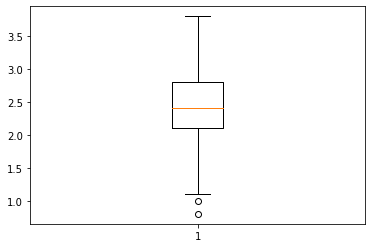

In [81]:
#plt.boxplot(estadias_urg)
s = np.std(estadias_opr, ddof=1)
mu = np.mean(estadias_opr)
iqr = stats.iqr(estadias_opr)
cota_superior = stats.scoreatpercentile(estadias_opr, 75) + 1.5*iqr
cota_inferior = max(stats.scoreatpercentile(estadias_div, 25) - 1.5*iqr, 0)
#cota_inferior = 0

estadias_opr_filtrada = [x for x in estadias_opr if cota_inferior < x <= cota_superior]

#iqr = stats.iqr(estadias_div_filtrada)
#cota_superior = stats.scoreatpercentile(estadias_div_filtrada, 75) + 3*iqr
#cota_inferior = max(stats.scoreatpercentile(estadias_div_filtrada, 75) - 3*iqr, 0)

#estadias_div_filtrada = [x for x in estadias_div_filtrada if cota_inferior < x <= cota_superior]
print(f'Rango: [{cota_inferior} - {cota_superior}]')
print(len(estadias_opr_filtrada)/ len(estadias_opr))
plt.boxplot(estadias_opr_filtrada)

(array([  2.,   7.,  23.,  43.,  67.,  97., 108.,  27.,  31.,   5.]),
 array([0.8, 1.1, 1.4, 1.7, 2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8]),
 <BarContainer object of 10 artists>)

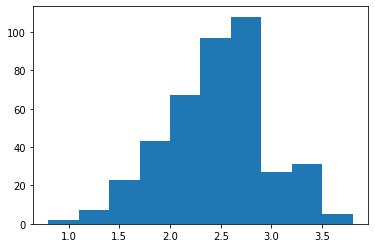

In [82]:
plt.hist(estadias_opr_filtrada)

,sumsquare_error,aic,bic,kl_div
powerlognorm,43.434011,337.659381,-896.350264,inf
skewnorm,43.435058,335.436631,-902.356538,inf
powernorm,43.436647,335.569170,-902.341530,inf
pearson3,43.438744,335.703135,-902.321741,inf
loggamma,43.439308,335.800122,-902.316415,inf


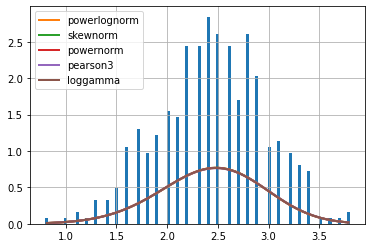

In [78]:
fit_opr = Fitter(estadias_opr_filtrada)
fit_opr.fit()
fit_opr.summary()

The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 43.434010546711264  and p value is: 4.385003471440996e-11
Null Hypothesis is rejected -> La distribución no ajusta los datos


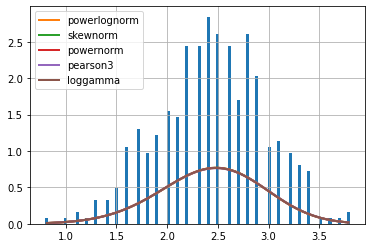

In [79]:
result_opr = fit_opr.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_opr['sumsquare_error'][0]

print("The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis -> La distribución ajusta los datos"

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected -> La distribución no ajusta los datos"
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

In [86]:
datos_operaciones.groupby(['SALA OPERACIONES'])['DURACION (hrs)'].mean()

SALA OPERACIONES
OPR101_011    2.329310
OPR101_033    2.462676
OPR102_001    2.390000
OPR102_003    2.456579
Name: DURACION (hrs), dtype: float64

In [89]:
estadias_OPR101_011 = datos_operaciones[datos_operaciones['SALA OPERACIONES']=='OPR101_011']['DURACION (hrs)']
estadias_OPR101_033 = datos_operaciones[datos_operaciones['SALA OPERACIONES']=='OPR101_033']['DURACION (hrs)']
estadias_OPR102_001 = datos_operaciones[datos_operaciones['SALA OPERACIONES']=='OPR102_001']['DURACION (hrs)']
estadias_OPR102_003 = datos_operaciones[datos_operaciones['SALA OPERACIONES']=='OPR102_003']['DURACION (hrs)']

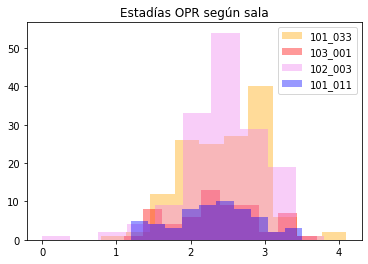

In [111]:
plt.hist(estadias_OPR101_033, alpha=0.4, label='101_033', color="orange")
plt.hist(estadias_OPR102_001, alpha=0.4, label='103_001', color="red")
plt.hist(estadias_OPR102_003, alpha=0.4, label='102_003', color='violet')
plt.hist(estadias_OPR101_011, alpha=0.4, label='101_011', color="blue")
plt.legend(loc='upper right')
plt.title('Estadías OPR según sala')
plt.show()

,sumsquare_error,aic,bic,kl_div
vonmises_line,96.178135,187.558806,41.515353,inf
triang,96.320871,200.903555,41.601366,inf
dgamma,96.412281,229.994644,41.656383,inf
gompertz,96.440067,194.602296,41.673096,inf
foldnorm,96.501352,200.503637,41.709941,inf


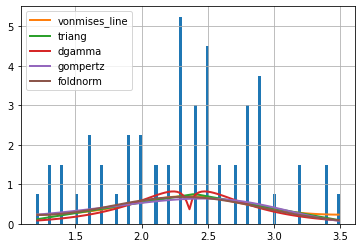

In [112]:
fit_opr_OPR101_011 = Fitter(estadias_OPR101_011)
fit_opr_OPR101_011.fit()
fit_opr_OPR101_011.summary()

The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 96.17813519042643  and p value is: 0.0
Null Hypothesis is rejected -> La distribución no ajusta los datos


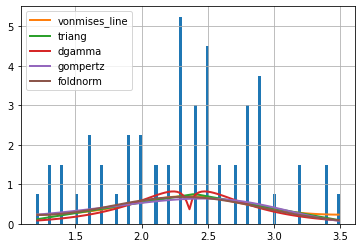

In [113]:
result_opr = fit_opr_OPR101_011.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_opr['sumsquare_error'][0]

print("The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis -> La distribución ajusta los datos"

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected -> La distribución no ajusta los datos"
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

/Users/martin/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4530: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


,sumsquare_error,aic,bic,kl_div
burr,40.125683,389.792079,-159.637776,inf
mielke,40.125687,389.792482,-159.637763,inf
weibull_min,40.339862,391.649228,-163.837665,inf
beta,40.367332,393.548979,-158.785173,inf
burr12,40.405268,389.857726,-158.651790,inf


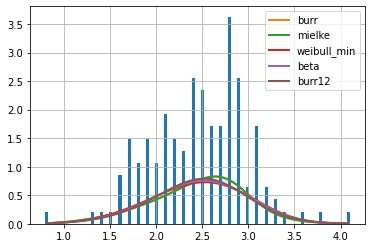

In [114]:
fit_opr_OPR101_033 = Fitter(estadias_OPR101_033)
fit_opr_OPR101_033.fit()
fit_opr_OPR101_033.summary()

The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 40.12568295800112  and p value is: 2.381373986892754e-10
Null Hypothesis is rejected -> La distribución no ajusta los datos


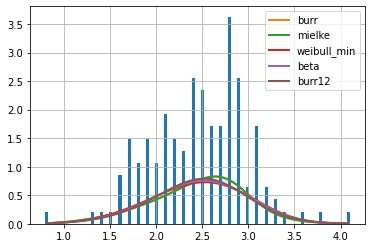

In [115]:
result_opr = fit_opr_OPR101_033.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_opr['sumsquare_error'][0]

print("The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis -> La distribución ajusta los datos"

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected -> La distribución no ajusta los datos"
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

Una forma de modelar esta distribución de manera muy rustica, es ajustar una distribución triangular para las estadias en las salas de operacion

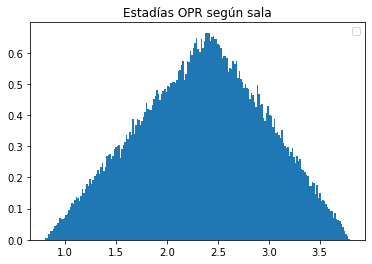

In [128]:
inf_range_opr = min(estadias_opr_filtrada)
sup_range_opr = max(estadias_opr_filtrada)
mean_opr = np.mean(estadias_opr_filtrada)

plt.hist(np.random.triangular(inf_range_opr, mean_opr, sup_range_opr, 100000), bins=200, density=True)
plt.legend(loc='upper right')
plt.title('Estadías OPR según sala')
plt.show()

In [154]:
posibles_estadias_opr = list(datos_operaciones['DURACION (hrs)'].value_counts().index)
freq_posibles_estadias_opr = datos_operaciones['DURACION (hrs)'].value_counts().reset_index(drop=True)

data = {
    'estadia': posibles_estadias_opr,
    'freq': freq_posibles_estadias_opr
}

distr_estadias_opr = pd.DataFrame(data)
distr_estadias_opr['prob'] = distr_estadias_opr['freq']/ distr_estadias_opr['freq'].sum()
distr_estadias_opr

,estadia,freq,prob
0,2.4,35,0.084951
1,2.8,32,0.077670
2,2.5,32,0.077670
3,2.2,30,0.072816
4,2.3,30,0.072816
5,2.6,30,0.072816
6,2.9,25,0.060680
7,2.7,21,0.050971
8,2.0,19,0.046117
9,2.1,18,0.043689


In [157]:
#distr_estadias_opr.to_csv('Prob_estadias_OPR.csv')  

Se almacena las posibles estadias en las operaciones y su probabilidad asociada.

### Distribución DIVs

In [40]:
DIVs = ['DIV101_603', 'DIV101_604','DIV102_203','DIV103_107', 'DIV103_204', 'DIV104_602', 'DIV101_703']
DIV_101_703 = ['DIV101_703']
URGs = ['URG101_003']

In [41]:
dic_distribuciones = dict.fromkeys(areas_mapa_profe)
estadias_div101_603 = np.array([])
estadias_div101_604 = np.array([])
estadias_div101_703 = np.array([])
estadias_div102_203 = np.array([])
estadias_div103_107 = np.array([])
estadias_div103_204 = np.array([])
estadias_div104_602 = np.array([])
estadias_div = np.array([])
estadias_urg = np.array([])

for area in areas_mapa_profe:
    try : 
        estadia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
        estadia = np.array(estadia)

        if area == 'URG101_003':
            estadias_urg = np.append(estadias_urg, estadia)
        elif area == 'DIV101_603':
            estadias_div101_603 = np.append(estadias_div101_603, estadia)
        elif area == 'DIV101_604':
            estadias_div101_604 = np.append(estadias_div101_604, estadia)
        elif area == 'DIV101_703':
            estadias_div101_703 = np.append(estadias_div101_703, estadia)
        elif area == 'DIV102_203':
            estadias_div102_203 = np.append(estadias_div102_203, estadia)
        elif area == 'DIV103_107':
            estadias_div103_107 = np.append(estadias_div103_107, estadia)
        elif area == 'DIV103_204':
            estadias_div103_204 = np.append(estadias_div103_204, estadia)
        elif area == 'DIV104_602':
            estadias_div104_602 = np.append(estadias_div104_602, estadia) 
        if area in DIVs:
            estadias_div = np.append(estadias_div, estadia)
    
    except:
        print('Hubo un error')

estadias_div101_603 = estadias_div101_603[estadias_div101_603 != 0]
estadias_div101_604 = estadias_div101_604[estadias_div101_604 != 0]
estadias_div101_703 = estadias_div101_703[estadias_div101_703 != 0]
estadias_div102_203 = estadias_div102_203[estadias_div102_203 != 0]
estadias_div103_107 = estadias_div103_107[estadias_div103_107 != 0]
estadias_div103_204 = estadias_div103_204[estadias_div103_204 != 0]
estadias_div104_602 = estadias_div104_602[estadias_div104_602 != 0]

In [36]:
print(f'Div101_603: {np.mean(estadias_div101_603)}')
print(f'Div101_604: {np.mean(estadias_div101_604)}')
print(f'Div101_703: {np.mean(estadias_div101_703)}')
print(f'Div102_203: {np.mean(estadias_div102_203)}')
print(f'Div103_107: {np.mean(estadias_div103_107)}')
print(f'Div103_204: {np.mean(estadias_div103_204)}')
print(f'Div104_602: {np.mean(estadias_div104_602)}')

#plt.hist(estadias_div101_603, bins=20);
#plt.hist(estadias_div101_604, bins=20);
#plt.hist(estadias_div101_703, bins=20);
plt.hist(estadias_div102_203, bins=20);
#plt.hist(estadias_div103_107, bins=20);
#plt.hist(estadias_div103_204, bins=20);
#plt.hist(estadias_div104_602, bins=20);


Div101_603: 280.7527777777778
Div101_604: 284.8571428571428
Div101_703: 9.371212121212121
Div102_203: 43.997058823529414
Div103_107: 251.17727272727276
Div103_204: 67.76614987080103
Div104_602: 199.54888888888888


Cantidad de datos de estadias: 1456


(array([1.377e+03, 4.000e+01, 1.500e+01, 7.000e+00, 1.300e+01, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([   0.        ,  110.05666667,  220.11333333,  330.17      ,
         440.22666667,  550.28333333,  660.34      ,  770.39666667,
         880.45333333,  990.51      , 1100.56666667]),
 <BarContainer object of 10 artists>)

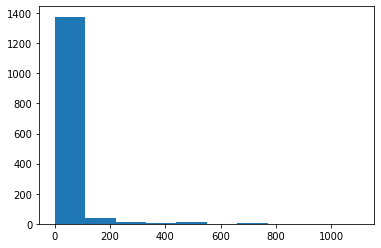

In [42]:
print(f'Cantidad de datos de estadias: {len(estadias_div)}')
plt.hist(estadias_div)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa32f80f040>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa32f80f610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa32f7fee80>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa32f80fbb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa32f80fe80>],
 'means': []}

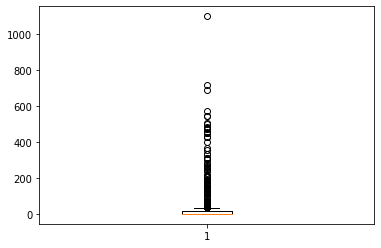

In [43]:
plt.boxplot(estadias_div)

0.25309734513274335


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa32fa476d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa32fa47c70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa32fa47400>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa32fa6b250>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa32fa6b520>],
 'means': []}

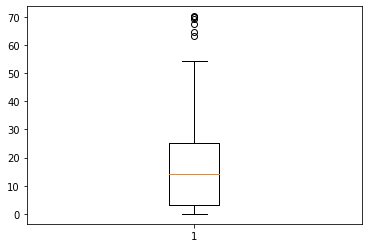

In [39]:
s = np.std(estadias_div, ddof=1)
mu = np.mean(estadias_div)
iqr = stats.iqr(estadias_div)
cota_superior = stats.scoreatpercentile(estadias_div, 75) + 3*iqr
#cota_inferior = max(stats.scoreatpercentile(estadias_div, 75) - 1.5*iqr, 0)
cota_inferior = 0

estadias_div_filtrada = [x for x in estadias_div if cota_inferior < x <= cota_superior]

#iqr = stats.iqr(estadias_div_filtrada)
#cota_superior = stats.scoreatpercentile(estadias_div_filtrada, 75) + 3*iqr
#cota_inferior = max(stats.scoreatpercentile(estadias_div_filtrada, 75) - 3*iqr, 0)

#estadias_div_filtrada = [x for x in estadias_div_filtrada if cota_inferior < x <= cota_superior]

print(len(estadias_div_filtrada)/ len(estadias_div))
plt.boxplot(estadias_div_filtrada)

Como se puede ver, luego de aplicar un filtro sobre los strong outliers, nos quedamos con el 56% de los datos de estadias en los div ya que gran parte de ellos eran valores 0s que no tenien sentido dentro del contexto de nuestro problema.

/Users/martin/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4530: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


,sumsquare_error,aic,bic,kl_div
johnsonsb,0.016833,920.613937,-1273.910841,inf
bradford,0.017230,918.582133,-1275.538984,inf
recipinvgauss,0.017648,974.579106,-1272.109432,inf
levy,0.018270,1048.699686,-1272.117744,inf
halfgennorm,0.018410,990.533628,-1266.063296,inf


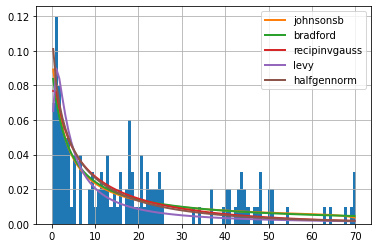

In [44]:
fit_divs = Fitter(estadias_div_filtrada)
fit_divs.fit()
fit_divs.summary()

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.016832501953262788  and p value is: 0.8967720298350979
Failed to reject the null hypothesis.


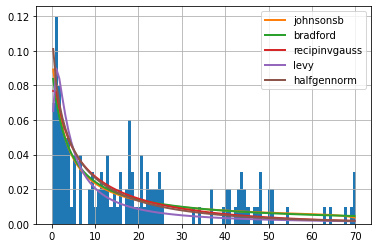

In [45]:
result_div = fit_divs.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_div['sumsquare_error'][0]

print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis."

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

,sumsquare_error,aic,bic,kl_div
gamma,0.018612,967.707132,-1264.499314,inf
exponpow,0.019042,948.984215,-1261.236980,inf
lognorm,0.021999,997.222656,-1240.592805,inf
expon,0.022224,956.713598,-1244.101250,inf
powerlaw,0.024566,884.985346,-1224.812092,inf


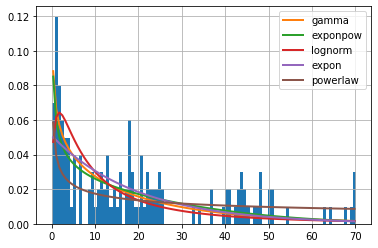

In [46]:
fit_common_divs = Fitter(estadias_div_filtrada, distributions = get_common_distributions())
fit_common_divs.fit()
fit_common_divs.summary()

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.018612469239901622  and p value is: 0.999997502688322
Failed to reject the null hypothesis.


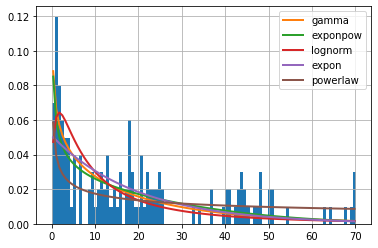

In [47]:
result_div = fit_common_divs.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_div['sumsquare_error'][0]

print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 5)
conclusion = "Failed to reject the null hypothesis."

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

,sumsquare_error,aic,bic,kl_div
expon,0.022224,956.713598,-1244.10125,inf


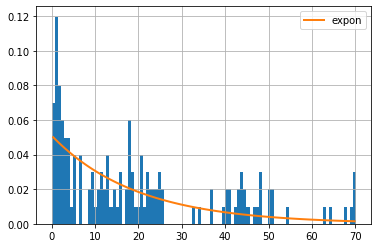

In [48]:
fit_expon_divs = Fitter(estadias_div_filtrada, distributions = ['expon'])
fit_expon_divs.fit()
fit_expon_divs.summary()

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.022224177027236797  and p value is: 0.8814922786903376
Failed to reject the null hypothesis.


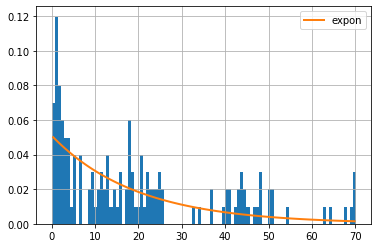

In [51]:
result_div = fit_expon_divs.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_div['sumsquare_error'][0]

print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis."

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

In [52]:
dic_distribuciones['DIV'] = fit_expon_divs.get_best()
dic_distribuciones['DIV'] # (location, scale)

{'expon': (0.016666666666666666, 19.637412587412584)}

### Distribución URGs

2.6080282227307396
874


(array([343., 196., 129.,  96.,  52.,  32.,  19.,   5.,   1.,   1.]),
 array([ 0.        ,  1.35333333,  2.70666667,  4.06      ,  5.41333333,
         6.76666667,  8.12      ,  9.47333333, 10.82666667, 12.18      ,
        13.53333333]),
 <BarContainer object of 10 artists>)

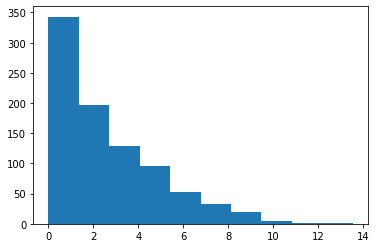

In [54]:
print(np.mean(estadias_urg))
print(len(estadias_urg))
plt.hist(estadias_urg)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa32f948520>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa32f948c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa32f948670>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa32fdd41f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa32fdd42e0>],
 'means': []}

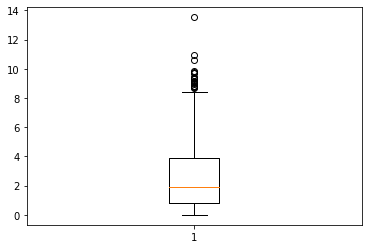

In [55]:
plt.boxplot(estadias_urg)

,sumsquare_error,aic,bic,kl_div
beta,0.079694,744.406346,-8103.416814,inf
exponweib,0.079804,722.330845,-8102.212743,inf
gengamma,0.080355,752.874324,-8096.198936,inf
gompertz,0.081410,756.292559,-8091.571462,inf
genexpon,0.081590,752.989280,-8076.090195,inf


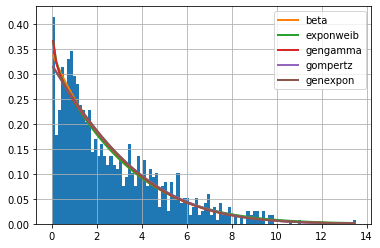

In [56]:
fit_urg = Fitter(estadias_urg)
fit_urg.fit()
fit_urg.summary()

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.07969394603527917  and p value is: 0.7777125946930997
Failed to reject the null hypothesis.


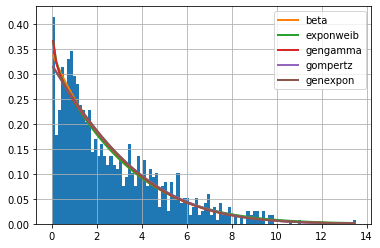

In [57]:
result_urg = fit_urg.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_urg['sumsquare_error'][0]

print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis."

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

,sumsquare_error,aic,bic,kl_div
gamma,0.083640,723.895962,-8067.952857,inf
expon,0.087701,714.629433,-8033.290019,inf
exponpow,0.091003,783.284018,-7994.207279,inf
lognorm,0.125726,723.348321,-7711.722933,inf
chi2,0.241647,757.126628,-7140.675930,inf


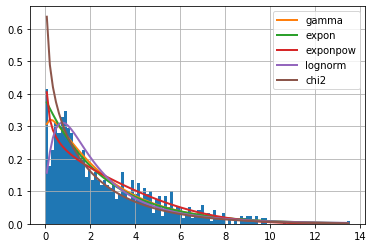

In [58]:
fit_common_urg = Fitter(estadias_urg, distributions= get_common_distributions())
fit_common_urg.fit()
fit_common_urg.summary()

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.08363982258175125  and p value is: 0.7724241214303732
Failed to reject the null hypothesis.


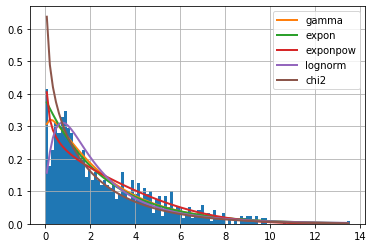

In [59]:
result_urg = fit_common_urg.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_urg['sumsquare_error'][0]

print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis."

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

,sumsquare_error,aic,bic,kl_div
expon,0.087701,714.629433,-8033.290019,inf


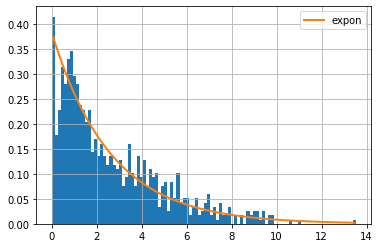

In [60]:
fit_expon_urg = Fitter(estadias_urg, distributions= ["expon"])
fit_expon_urg.fit()
fit_expon_urg.summary()

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.08770064641715104  and p value is: 0.7671209154163832
Failed to reject the null hypothesis.


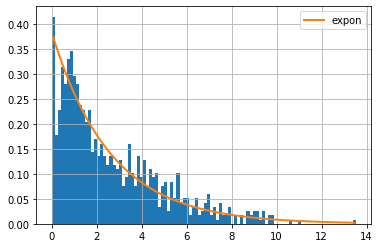

In [61]:
result_urg = fit_expon_urg.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_urg['sumsquare_error'][0]

print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis."

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

In [62]:
dic_distribuciones['URG'] = fit_expon_urg.get_best()
dic_distribuciones['URG']   # (location, scale)

{'expon': (0.0, 2.6080282227307396)}

# Ajuste a exponencial para la validación teorica de la simulación
Con estas tasas se realiza el modelo MMK con el que se ve la tasa de ocupación y podemos saber si la simluación debería diverger o no.

,sumsquare_error,aic,bic,kl_div
expon,0.00231,3132.805283,-6997.48966,inf


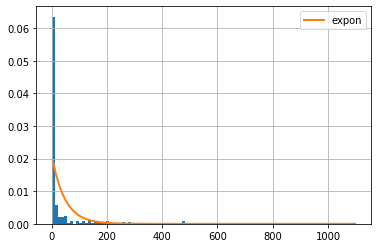

In [122]:
fit_estadias_div_exp = Fitter(estadias_div, distributions=["expon"])
fit_estadias_div_exp.fit()
fit_estadias_div_exp.summary()

In [84]:
fit_estadias_div_exp.get_best(method = "sumsquare_error")

{'expon': {'loc': 0.0, 'scale': 46.626873156342185}}

,sumsquare_error,aic,bic,kl_div
expon,0.04383,1799.537581,-18699.935716,inf


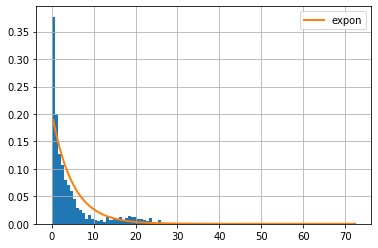

In [85]:
fit_estadias_urg_exp = Fitter(estadias_urg, distributions=["expon"])
fit_estadias_urg_exp.fit()
fit_estadias_urg_exp.summary()

In [86]:
fit_estadias_urg_exp.get_best(method = "sumsquare_error")

{'expon': {'loc': 0.0, 'scale': 4.912511803588291}}

,sumsquare_error,aic,bic,kl_div
expon,29.8361,350.31629,-1069.583318,inf


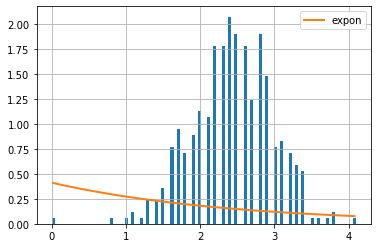

In [91]:
fit_estadias_opr_exp = Fitter(datos_operaciones['DURACION (hrs)'], distributions=["expon"])
fit_estadias_opr_exp.fit()
fit_estadias_opr_exp.summary()

In [92]:
fit_estadias_opr_exp.get_best(method = "sumsquare_error")

{'expon': {'loc': 0.0, 'scale': 2.4310679611650485}}